In [266]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree
import os
import sys

In [267]:
initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_220714_lite.fits')

In [268]:
grids = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

In [269]:
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [270]:
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])

In [271]:
initial_values['grid_index'] = np.array([grid_index_tree.query([tgf[0]/1000.,tgf[1],tgf[2]]) for tgf in np.array([initial_values['teff'],initial_values['logg'],initial_values['fe_h']]).T])[:,1]

In [272]:
indices = initial_values['grid_index']
priority = Table()
d,c = np.unique(indices, return_counts=True)
priority['index_subgrid'] = np.array(d,dtype=int)
priority['counts_dr4_init'] = np.array(c,dtype=int)
priority = join(priority, grids, keys='index_subgrid')
priority.sort(keys='counts_dr4_init',reverse=True)

In [273]:
def test_grid_index_computations(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -1.00:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_done:
                        if t[0] not in grids_started:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                            else:
                                print(str(t[0])+',')
                        else:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already started')
                    else:
                        if print_all_points:
                            print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [274]:
def test_grid_index_ready_for_training(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -1.00:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_converted_to_nn_input:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' not ready')
                    else:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [289]:
def test_progress():
    
    number_points_calculated_all = []
    number_points_needed_all = []
    
    for test_grid_index in grids['index_subgrid']:#[grids_converted_to_nn_input]:

        # Find upper and lower Teff points
        test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
        if test_grid_teff <= 4000:
            test_grid_teff_lower = test_grid_teff - 100
        else:
            test_grid_teff_lower = test_grid_teff - 250
        if test_grid_teff <= 3900:
            test_grid_teff_higher = test_grid_teff + 100
        else:
            test_grid_teff_higher = test_grid_teff + 250

        # Find upper and lower logg points
        test_grid_logg = grids['logg_subgrid'][test_grid_index]
        test_grid_logg_lower = test_grid_logg - 0.5
        test_grid_logg_higher = test_grid_logg + 0.5

        # Find upper and lower fe_h points
        test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
        if test_grid_fe_h <= -1.00:
            test_grid_fe_h_lower = test_grid_fe_h - 0.5
        else:
            test_grid_fe_h_lower = test_grid_fe_h - 0.25
        if test_grid_fe_h <= -1.5:
            test_grid_fe_h_higher = test_grid_fe_h + 0.5
        else:
            test_grid_fe_h_higher = test_grid_fe_h + 0.25

        number_points_calculated_each = 0
        number_points_needed_each = 0
        next_needed = None
        
        for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
            for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
                for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                    
                    t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                    
                    if len(t) > 0:
                        number_points_needed_each += 1
                        if t[0] in grids_converted_to_nn_input:
                            number_points_calculated_each += 1
                        else:
                            next_needed = t[0]
                    else:
                        # there is no grid point for this one.
                        pass

        number_points_calculated_all.append(number_points_calculated_each)
        number_points_needed_all.append(number_points_needed_each)
        
        try:
            counts = priority['counts_dr4_init'][priority['index_subgrid']==test_grid_index][0]
            if counts < 10:
                counts = str(counts)+'    '
            elif counts < 100:
                counts = str(counts)+'   '
            elif counts < 1000:
                counts = str(counts)+'  '
            elif counts < 10000:
                counts = str(counts)+' '
            else:
                counts = str(counts)
        except:
            counts = 'none '
            
        space = ''
        if test_grid_fe_h >= 0:
            space = ' '

        if number_points_calculated_each == number_points_needed_each:
            if test_grid_index in trained_3x3x3:
                pass
                # print(str(test_grid_index)+' trained 3x3x3')
            else:
                print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' -----------------------------------------------------      TRAIN!!!')
        elif number_points_calculated_each > number_points_needed_each - 7:
            if next_needed in grids_done:
                print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                             CONVERT')
            elif next_needed in grids_started:
                print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                PBS running')
            else:
                print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, ' Submit to PBS!')

In [290]:
grids_started = [
951,
952,
953,
963,
964,
965,
975,
976,
977,
1125,
1126,
1137,
1138,
1147,
1149,
1150,
1247,
1248,
1356,
1357,
1383,
1278,
1295,
1402,
1525,
1564,
1577,
2238,
2358,
2359,
]
print(len(grids_started))

30


In [291]:
grids_done = [
    478, # for analysis of 131216001101084
    829,
    830,831,
    840,841,842,
    851,852,853,
    1075,1076,1077,
    1087,1088,1089,
    1098,1099,
    1100,
    1109,1110,1111,1112,
    1120,1121,1122,1123,1124,
    1132,1133,1134,1135,1136,
    1148,
    1198,1199,
    1200,
    1210,1211,1212,
    1221,1222,1223,
    1231,1232,1233,1234,
    1241,1242,1243,1244,1245,1246,
    1253,1254,1255,1256,1257,1258,1259,
    1260,1261,
    1266,1267,1268,1269,
    1270,1271,
    1272,1273,1274,
    1279,
    1280,1281,1282,1283,1284,1285,1286,1287,
    1296,1297,1298,
    1320,1321,1322,
    1332,1333,1334,
    1340,1341,1342,1343,
    1350,1351,1352,1353,1354,1355,
    1362,1363,1364,1365,1366,1367,1368,1369,
    1370,
    1375,1376,1377,1378,1379,
    1380,1381,1382,
    1387,1388,1389,
    1390,1391,1392,1393,1394,1395,1396,
    1403,1404,1405,1406,1407,
    1429,
    1430,1431,
    1441,1442,1443,
    1446,1447,1448,1449,
    1456,1457,1458,1459,
    1460,1461,
    1468,1469,
    1470,1471,1472,1473,1474,1475,1476,
    1481,1482,1483,1484,1485,1486,1487,1488,1489,
    1493,1494,1495,1496,1497,1498,1499,
    1500,1501,1502,
    1505,1506,1507,1508,1509,
    1510,1511,1512,1513,
    1535,1536,1537,
    1546,1547,1548,1549,
    1550,
    1552,1553,
    1560,1561,1562,1563,
    1572,1573,1574,1575,1576,
    1584,1585,1586,1587,1588,1589,
    1590,1591,1592,
    1596,1597,1598,1599,
    1600,1601,1602,1603,1604,
    1608,1609,
    1610,1611,1612,1613,1614,1615,1616,
    1620,1621,1622,1623,
    1626,1627,1628,1629,
    1636,1637,1638,1639,
    1640,1641,
    1648,1649,
    1650,1651,1652,1653,
    1671,1672,1673,1674,
    1683,1684,1685,1686,
    1695,1696,1697,1698,
    1707,1708,1709,1710,
    1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,
    1735,1736,1737,1738,1739,1740,   
    1747,1748,1749,
    1750,1751,1752,
    1790,1791,1792,1793,
    1802,1803,1804,1805,
    1809,
    1814,1815,1816,1817,1818,1819,
    1820,1821,1822,1823,
    1830,1831,1832,1833,1834,1835,
    1842,1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1892,1893,1894,1895,1896,1897,
    1900,1901,1902,
    1904,1905,1906,1907,1908,1909,
    1910,
    1916,1917,1918,1919,
    1920,1921,1922,
    1928,1929,
    1930,1931,1932,1933,1934,
    1975,1976,1977,1978,1979,
    1980,
    1987,1988,1989,
    1990,1991,1992,1993,
    1999,
    2000,2001,2002,2003,2004,2005,
    2011,2012,2013,2014,2015,2016,2017,
    2052,2053,2054,2055,2056,2057,
    2064,2065,2066,2067,2068,2069,
    2070,
    2076,2077,2078,2079,
    2080,2081,2082,
    2088,2089,
    2090,2091,2092,2093,2094,
    2127,2128,2129,
    2130,
    2137,2138,2139,
    2140,2141,2142,2143,
    2149,
    2150,2151,2152,2153,2154,2155,
    2161,2162,2163,2164,2165,2166,2167,
    2211,2212,2213,
    2223,2224,2225,
    2235,2236,2237,
    2346,2347,2348,
    2360,
    2370,2371,2372,
    2398,2399,
    2400,
    2409,
    2410,2411,2412,2413,
    2421,2422,2423,2424,2425,
    2433,2434,2435,2436,2437,
    2457,2458,2459,
    2460,
    2469,
    2470,2471,2472,2473,
    2481,2482,2483,2484,2485,
    2493,2494,2495,2496,2497,
]
print(len(grids_done),len(grids_done) * 280)

487 136360


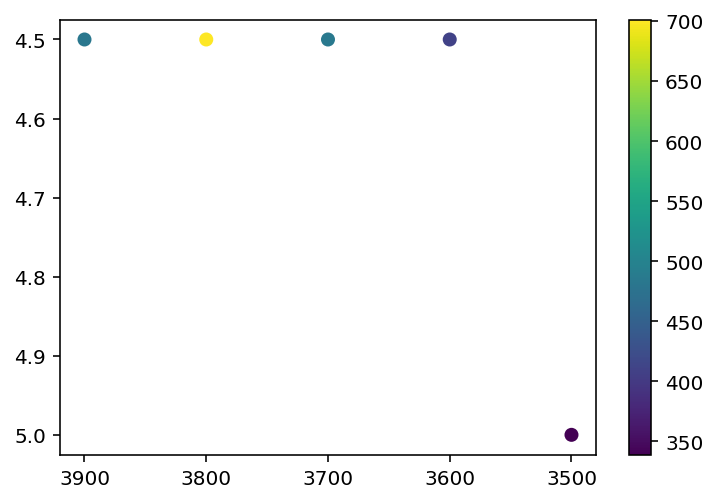

[964, 841, 1088, 718, 605]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
964,701,3800.0,3700.0,3900.0,4.5,4.0,5.0,0.0,-0.25,0.25,3845,3800_4.50_0.00
841,486,3700.0,3600.0,3800.0,4.5,4.0,5.0,0.0,-0.25,0.25,3745,3700_4.50_0.00
1088,483,3900.0,3800.0,4000.0,4.5,4.0,5.0,0.0,-0.25,0.25,3945,3900_4.50_0.00
718,410,3600.0,3500.0,3700.0,4.5,4.0,5.0,0.0,-0.25,0.25,3645,3600_4.50_0.00
605,339,3500.0,3400.0,3600.0,5.0,4.5,5.5,0.0,-0.25,0.25,3550,3500_5.00_0.00


In [292]:
# selection = (priority['fe_h_subgrid'] <= -2) & (priority['counts_dr4_init'] > 200)
# selection = (priority['fe_h_subgrid'] <= -1.5) & (priority['counts_dr4_init'] > 200) & (priority['teff_subgrid'] <= 6000)
# selection = (priority['fe_h_subgrid'] <= -0.75) & (priority['counts_dr4_init'] > 2800)
# selection = (priority['teff_subgrid'] == 7250) & (priority['counts_dr4_init'] > 200)
selection = (priority['counts_dr4_init'] <= 10000) & (priority['counts_dr4_init'] > 8000)
selection = (priority['teff_subgrid'] <= 3999) &(priority['logg_subgrid'] >= 4.0) & (priority['counts_dr4_init'] > 290)



f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection] + np.abs(100*priority['fe_h_subgrid'][selection]),
    priority['logg_subgrid'][selection] + 0.1*priority['fe_h_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

print(list(priority['index_subgrid'][selection]))

priority[selection]

In [293]:
# ALREADY DONE
selection = [
    2002, 1499, 2001, 1919, 2078, 2079, 1918, 1394, 1500, 1931, 1920, 1845,
    1930, 2151, 1498, 2482, 1833, 2014, 1844, 1750,
    2003, 2000, 1381,
    964,
    1211,
    1259,
    1333,
    1442
]

# selection = []

for t in selection:
    test_grid_index_computations(t)

In [294]:
grids_converted_to_nn_input = [
    478,
    829,
    830,831,
    840,841,
    1109,1110,1111,1112,
    1120,1121,1122,1123,1124,
    1132,1133,1134,1135,1136,
    1148,
    1198,1199,
    1200,
    1210,1211,1212,
    1221,1222,1223,
    1231,1232,1233,1234,
    1241,1242,1243,1244,1245,1246,
    1253,1254,1255,1256,1257,1258,1259,
    1260,1261,
    1266,1267,1268,1269,
    1270,1271,
    1272,1273,1274,
    1279,
    1280,1281,1282,1283,1284,1285,1286,1287,
    1296,1297,1298,
    1320,1321,1322,
    1332,1333,1334,
    1340,1341,1342,1343,
    1350,1351,1352,1353,1354,1355,
    1362,1363,1364,1365,1366,1367,1368,1369,
    1370,
    1375,1376,1377,1378,1379,
    1380,1381,1382,
    1387,1388,1389,
    1390,1391,1392,1393,1394,1395,1396,
    1403,1404,1405,1406,1407,
    1429,
    1430,1431,
    1441,1442,1443,
    1446,1447,1448,1449,
    1456,1457,1458,1459,
    1460,1461,
    1468,1469,
    1470,1471,1472,1473,1474,1475,1476,
    1481,1482,1483,1484,1485,1486,1487,1488,1489,
    1493,1494,1495,1496,
    1497,1498,1499,
    1500,1501,1502,
    1505,1506,1507,1508,1509,
    1510,1511,1512,1513,
    1535,1536,1537,
    1546,1547,1548,1549,
    1550,1552,1553,
    1560,1561,1562,1563,
    1572,1573,1574,1575,1576,
    1584,1585,1586,1587,1588,1589,
    1590,1591,1592,
    1596,1597,1598,1599,
    1600,1601,1602,1603,1604,
    1608,1609,
    1610,1611,1612,1613,1614,1615,1616,
    1620,1621,1622,1623,
    1626,1627,1628,1629,
    1636,1637,1638,1639,
    1640,1641,
    1648,1649,
    1650,1651,1652,1653,
    1695,1696,1697,
    1671,1672,1673,1674,
    1683,1684,1685,1686,
    1698,
    1707,1708,1709,
    1710,
    1719,
    1720,1721,1722,1723,
    1724,1725,1726,1727,1728,
    1735,1736,1737,1738,1739,1740,
    1747,1748,1749,
    1750,1751,1752,
    1790,1791,1792,1793,
    1802,1803,1804,1805,
    1809,
    1814,1815,1816,1817,
    1818,1819,
    1820,1821,1822,1823,
    1830,1831,1832,1833,1834,1835,
    1842,1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1892,
    1893,1894,1895,1896,1897,
    1900,1901,1902,
    1904,1905,1906,1907,1908,1909,
    1910,
    1916,1917,1918,1919,
    1920,1921,1922,
    1928,1929,
    1930,1931,1932,1933,1934,
    1975,1976,1977,1978,1979,
    1980,
    1987,1988,1989,
    1990,1991,1992,1993,
    1999,
    2000,2001,2002,2003,2004,2005,
    2011,2012,2013,2014,2015,2016,2017,
    2052,2053,2054,2055,2056,2057,
    2064,2065,2066,2067,2068,2069,
    2070,
    2076,2077,2078,2079,
    2080,2081,2082,
    2088,2089,
    2090,2091,2092,2093,2094,
    2127,2128,2129,
    2130,
    2137,2138,2139,
    2140,2141,2142,2143,
    2149,
    2150,2151,2152,2153,2154,2155,
    2161,2162,2163,2164,2165,2166,2167,
    2211,2212,2213,
    2223,2224,2225,
    2235,2236,2237,
    2346,2347,2348,
    2360,
    2370,2371,2372,
    2398,2399,
    2400,
    2409,
    2410,2411,2412,
    2413,
    2421,2422,2423,2424,2425,
    2433,2434,2435,2436,2437,
    2457,2458,2459,
    2460,
    2469,
    2470,2471,2472,2473,
    2481,2482,2483,2484,2485,
    2493,2494,2495,2496,2497,
]
print(len(grids_converted_to_nn_input))

474


In [295]:
trained_3x3x3 = [
    1231,
    1232, # Training with 6415 spectra (89%), Testing with 713 spectra (10%), 9033.599 validation loss = 8952.251
    1233, # Training with 6679 spectra (89%), Testing with 743 spectra (10%), 8569.789 validation loss = 8407.385
    1243,
    1244, # Training with 11232 spectra (90%), Testing with 1248 spectra (10%), 8918.089 validation loss = 8923.438
    1245,
    1340,
    1341,1342,
    1350,1351,
    1354,
    1364, # Training with 9423 spectra (90%), Testing with 1047 spectra (10%), 9559.972 validation loss = 9560.110, 22.216 validation loss = 23.934
    1365, # Training with 10330 spectra (89%), Testing with 1148 spectra (10%), 9244.988 validation loss = 9285.615
    1366, # Training with 9536 spectra (89%), Testing with 1060 spectra (10%), 8949.833 validation loss = 8970.894
    1377,
    1379,
    1380,1381,
    1446, # Training with 4035 spectra (89%), Testing with 449 spectra (10%), 9751.414 validation loss = 9754.023, 24.017 validation loss = 25.208
    1447, # Training with 5239 spectra (89%), Testing with 583 spectra (10%), 9573.558 validation loss = 9554.650
    1458, # Training with 8748 spectra (89%), Testing with 973 spectra (10%), 9678.605 validation loss = 9680.667, 19.176 validation loss = 18.841
    1459, # Training with 10179 spectra (89%), Testing with 1132 spectra (10%), 9354.261 validation loss = 9443.805
    1470, # Training with 9915 spectra (89%), Testing with 1102 spectra (10%), 9699.579 validation loss = 9660.728
    1471, # Training with 10410 spectra (89%), Testing with 1157 spectra (10%), 9457.726 validation loss = 9459.764
    1482, # Training with 10002 spectra (89%), Testing with 1112 spectra (10%), 9663.655 validation loss = 9652.573,
    1483, # Training with 10544 spectra (89%), Testing with 1172 spectra (10%), 9465.517 validation loss = 9439.481, 25.909 validation loss = 26.766
#     1497, # rerun wrong lower feh
    1498,1499,
    1352,
    1353,
    1378,
    1484,
    1546,
    1585,
    1586, # Training with 11475 spectra (90%), Testing with 1275 spectra (10%), 9513.832 validation loss = 9504.287
    1597,
    1598,
    1651,
    1708, # Training with 11333 spectra (89%), Testing with 1260 spectra (10%), 
    1709,
    1738,1739,
#     1747, # rerun wrong lower feh
    1748,
    1749, # Training with 8410 spectra (89%), Testing with 935 spectra (10%), 9122.635 validation loss = 9003.748, 40.247 validation loss = 43.474
    1750,1751,
    1803,
    1831,1832,1833,1834,
#     1842,  # rerun wrong lower feh
    1843,1844,1845,1846,
#     1916, # rerun wrong lower feh
    1917,1918,1919,
    1920, # Training with 10884 spectra (89%), Testing with 1210 spectra (10%), 8908.265 validation loss = 8927.847
#     1928, # rerun wrong lower feh
    1929,
    1930, # Training with 8631 spectra (90%), Testing with 959 spectra (10%), 9365.203 validation loss = 9314.398
    1931,
    1932, # Training with 8355 spectra (89%), Testing with 929 spectra (10%), 8988.107 validation loss = 8910.192, 35.799 validation loss = 39.891
    1988,1989,
    1990,1991,
#     1999, # rerun wrong lower feh
    2000,
    2001, # Training with 12441 spectra (89%), Testing with 1383 spectra (10%), 9266.918 validation loss = 9256.894, 21.200 validation loss = 21.490
    2002,
    2003, # Training with 11946 spectra (89%), Testing with 1328 spectra (10%), 9006.185 validation loss = 8993.563,
#     2011, # rerun wrong lower feh
    2012,
    2013, # Training with 9369 spectra (90%), Testing with 1041 spectra (10%), 9359.681 validation loss = 9390.210
    2014, # Training with 9301 spectra (89%), Testing with 1034 spectra (10%), 9220.544 validation loss = 9255.023
    2015, # Training with 9162 spectra (90%), Testing with 1018 spectra (10%), 9057.569 validation loss = 9055.459,
    2016, # Training with 9016 spectra (89%), Testing with 1002 spectra (10%), 8809.333 validation loss = 8878.590
    2017,
    2067,2068,
#     2076, # rerun wrong lower feh
    2077,2078,2079,
    2080,2081,2082,
#     2088, # rerun wrong lower feh
    2089,
    2090, # Training with 9532 spectra (89%), Testing with 1060 spectra (10%), 9431.687 validation loss = 9428.241, 18.959 validation loss = 19.571
    2091, # Training with 9648 spectra (90%), Testing with 1072 spectra (10%), 9301.318 validation loss = 9283.762, 23.940 validation loss = 24.879
    2092,
    2093,
    2094,
#     2137, # rerun wrong lower feh
    2151,
    2163,
    2470, # Training with 9504 spectra (90%), Testing with 1056 spectra (10%), 9469.946 validation loss = 9458.486
    2482, # Training with 9360 spectra (90%), Testing with 1040 spectra (10%), 9466.776 validation loss = 9453.214
    2483,
    2484,
    2494,
    2495, # Training with 6595 spectra (89%), Testing with 733 spectra (10%), 9459.075 validation loss = 9470.328, 15.142 validation loss = 14.623
    2496,
# CURRENT GRIDS IN LOOP WITH TRAIN
# CURRENT GRIDS IN LOOP WITH TRAIN2
]

# Currently running:
# Train1: 1333,1442,1548
# Train2: 2004,2005

# could train: 

print('Trained 3x3x3 for '+str(len(trained_3x3x3)))

raise ValueError('Not running testing training progress script')
print('Updating galah_dr4_model_trainingset_gridpoints_trained.fits!')
os.system('ipython galah_dr4_model_trainingset_gridpoints_test_training.py');
print('Updated')

Trained 3x3x3 for 101


ValueError: Not running testing training progress script

In [296]:
s = []
for grid_p in grids_done:
    if grid_p not in grids_converted_to_nn_input:
        print(str(grid_p)+',')
        s.append(grid_p)
print(len(s))
print('import os')
print('ps = ['+','.join([str(x) for x in s])+']')
print('for p in ps:')
print("    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))")

842,
851,
852,
853,
1075,
1076,
1077,
1087,
1088,
1089,
1098,
1099,
1100,
13
import os
ps = [842,851,852,853,1075,1076,1077,1087,1088,1089,1098,1099,1100]
for p in ps:
    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))


In [297]:
# Currently converting
# t1: 842,851,852,853,1075
# t2: 1076,1077,1087,1088
# t3: 1089,1098,1099,1100

In [285]:
test_progress()

1109 4000_0.50_-2.00 2     only 5 more: 999  Submit to PBS!
1110 4000_0.50_-1.50 21    only 6 more: 1000  Submit to PBS!
1111 4000_0.50_-1.00 62    only 6 more: 1001  Submit to PBS!
1119 4000_1.00_-3.00 none  only 6 more: 1131  Submit to PBS!
1222 4000_5.00_0.00  15    only 6 more: 1100                              CONVERT
1241 4250_1.00_-3.00 none  only 2 more: 1131  Submit to PBS!
1242 4250_1.00_-2.50 none  only 2 more: 1131  Submit to PBS!
1253 4250_1.50_-3.00 none  only 6 more: 1374  Submit to PBS!
1255 4250_1.50_-2.00 14    only 3 more: 1146  Submit to PBS!
1256 4250_1.50_-1.50 37    only 3 more: 1147                 PBS running
1257 4250_1.50_-1.00 449   only 2 more: 1147                 PBS running
1258 4250_1.50_-0.75 2956  only 6 more: 1356                 PBS running
1268 4250_2.00_-1.50 3     only 6 more: 1159  Submit to PBS!
1269 4250_2.00_-1.00 25    only 5 more: 1160  Submit to PBS!
1270 4250_2.00_-0.75 299   only 6 more: 1161  Submit to PBS!
1333 4250_4.50_0.00  1532  --

2153 6500_4.00_0.25  959   only 6 more: 2239  Submit to PBS!
2155 6500_4.00_0.75  47    only 6 more: 2240  Submit to PBS!
2162 6500_4.50_-0.50 120   only 2 more: 2234  Submit to PBS!
2164 6500_4.50_0.00  472   only 2 more: 2238                 PBS running
2165 6500_4.50_0.25  169   only 4 more: 2239  Submit to PBS!
2166 6500_4.50_0.50  66    only 6 more: 2240  Submit to PBS!
2167 6500_4.50_0.75  21    only 4 more: 2240  Submit to PBS!
2236 6750_4.50_-0.25 49    only 6 more: 2307  Submit to PBS!
2410 7500_3.50_-0.25 468   only 5 more: 2359                 PBS running
2422 7500_4.00_-0.25 4830  only 2 more: 2359                 PBS running
2423 7500_4.00_0.00  350   only 4 more: 2373  Submit to PBS!
2424 7500_4.00_0.25  224   only 6 more: 2374  Submit to PBS!
2434 7500_4.50_-0.25 10    only 2 more: 2359                 PBS running
2435 7500_4.50_0.00  21    only 3 more: 2373  Submit to PBS!
2436 7500_4.50_0.25  15    only 4 more: 2374  Submit to PBS!
2458 7750_3.00_-0.25 none  only 6 mor

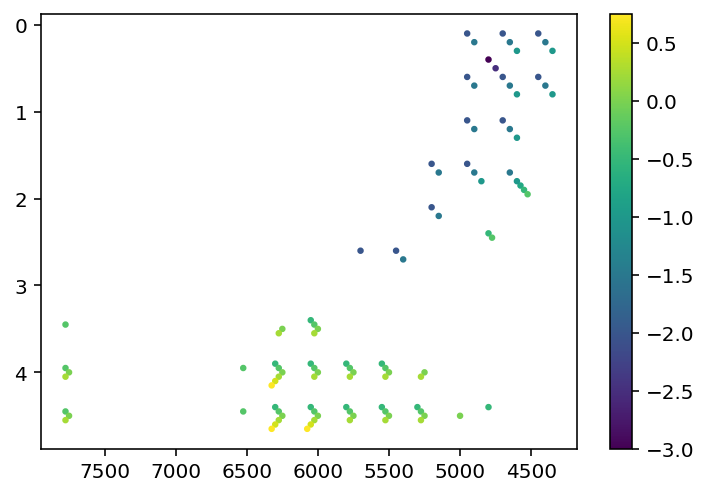

In [286]:
selection = trained_3x3x3

f, ax = plt.subplots()
s = ax.scatter(
    grids['teff_subgrid'][selection] + np.abs(100*grids['fe_h_subgrid'][selection]),
    grids['logg_subgrid'][selection] + 0.2*grids['fe_h_subgrid'][selection],
    c = grids['fe_h_subgrid'][selection], s = 5
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()